In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
from scipy import stats
import metpy.calc as mpcalc
from metpy.units import units
from IPython.display import Image, display

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import independent_ttest, persistence

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
yaml_doc = '../data/config.yml'

config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
# djf_dict mam_dict djfmam_dict
ssn = 'mam'
ar_dict = config[ssn]

In [4]:
ref = 'daily'

fname_daily = 'teleconnection_indices/norm.daily.ao.index.b500101.current.ascii'
fname_monthly = 'teleconnection_indices/AO_CPC_NOAA_monthly_index_1950_2019.txt'

if ref == 'monthly':
    names=['year', 'month', 'anom']
    df = pd.read_csv(path_to_data + fname_monthly,
                    delim_whitespace=True, engine='python', header=0, names=names)

    df['3_month_running'] = df.loc[:,'anom'].rolling(window=3).mean()
    df['COND'] = 'NEUTRAL'
    df.loc[df['3_month_running']>0, 'COND'] = 'POSITIVE'
    df.loc[df['3_month_running']<0, 'COND'] = 'NEGATIVE'
    df = df.loc[(df['year'] >= 1980) & (df['year'] <= 2018)]
    AO_df = df.loc[(df['month'] == 12) | (df['month'] == 3) | (df['month'] == 6) | (df['month'] == 9)]

if ref == 'daily':
    names=['YEAR', 'MON', 'DAY', 'ANOM']
    df = pd.read_csv(path_to_data + fname_daily,
                    delim_whitespace=True, engine='python', header=0, names=names)
    df['COND'] = 'NEUTRAL'
    df.loc[df['ANOM']>0, 'COND'] = 'POSITIVE'
    df.loc[df['ANOM']<0, 'COND'] = 'NEGATIVE'
    df['date'] = pd.date_range('1950-01-02 9:00:00', '2019-02-28 9:00:00', freq='1D')
    df = df.set_index('date')
    
    # Trim date range
    idx = (df.index >= ar_dict['start_date']) & (df.index <= '2018-6-1')
    df = df.loc[idx]

    # Select months
    if ar_dict['mon_s'] > ar_dict['mon_e']:
        idx = (df.MON >= ar_dict['mon_s']) | (df.MON <= ar_dict['mon_e'])
    else:
        idx = (df.MON >= ar_dict['mon_s']) & (df.MON <= ar_dict['mon_e'])

    df = df.loc[idx]

df

,YEAR,MON,DAY,ANOM,COND
date,,,,,
1979-03-01 09:00:00,1979,3,1,0.372,POSITIVE
1979-03-02 09:00:00,1979,3,2,0.737,POSITIVE
1979-03-03 09:00:00,1979,3,3,1.127,POSITIVE
1979-03-04 09:00:00,1979,3,4,1.264,POSITIVE
1979-03-05 09:00:00,1979,3,5,1.414,POSITIVE
...,...,...,...,...,...
2018-05-27 09:00:00,2018,5,27,0.861,POSITIVE
2018-05-28 09:00:00,2018,5,28,1.036,POSITIVE
2018-05-29 09:00:00,2018,5,29,0.665,POSITIVE


In [5]:
fname_id = 'HUV500t0120050cor'
filepath = path_to_out + fname_id + 'hma_AR-types-' + ssn + '.csv'
df2 = pd.read_csv(filepath)
df2['date'] = pd.to_datetime(df2['Unnamed: 0'])
df2 = df2.drop(columns=['Unnamed: 0'])
df2 = df2.set_index('date')

## Separate the AR Types into multiple columns
df2['AR_CAT1'] = 0
df2['AR_CAT2'] = 0
df2['AR_CAT3'] = 0

idx = (df2['AR_CAT'] == 1) 
df2.loc[idx, 'AR_CAT1'] = 1

idx = (df2['AR_CAT'] == 2) 
df2.loc[idx, 'AR_CAT2'] = 1

idx = (df2['AR_CAT'] == 3) 
df2.loc[idx, 'AR_CAT3'] = 1
df2

,AR_CAT,AR_CAT1,AR_CAT2,AR_CAT3
date,,,,
1979-03-01 09:00:00,0,0,0,0
1979-03-02 09:00:00,0,0,0,0
1979-03-03 09:00:00,0,0,0,0
1979-03-04 09:00:00,0,0,0,0
1979-03-05 09:00:00,0,0,0,0
...,...,...,...,...
2018-05-27 09:00:00,0,0,0,0
2018-05-28 09:00:00,0,0,0,0
2018-05-29 09:00:00,0,0,0,0


In [6]:
## join MJO df and ar df
new_df1 = df2.join(df)
# select only AR DAYS
idx = (new_df1['AR_CAT'] > 0)
new_df = new_df1.loc[idx]
new_df

,AR_CAT,AR_CAT1,AR_CAT2,AR_CAT3,YEAR,MON,DAY,ANOM,COND
date,,,,,,,,,
1979-03-08 09:00:00,2,0,1,0,1979,3,8,0.770,POSITIVE
1979-03-09 09:00:00,2,0,1,0,1979,3,9,0.031,POSITIVE
1979-03-18 09:00:00,2,0,1,0,1979,3,18,-2.917,NEGATIVE
1979-03-28 09:00:00,1,1,0,0,1979,3,28,-1.374,NEGATIVE
1979-04-05 09:00:00,2,0,1,0,1979,4,5,-2.955,NEGATIVE
...,...,...,...,...,...,...,...,...,...
2018-03-13 09:00:00,1,1,0,0,2018,3,13,-1.385,NEGATIVE
2018-03-15 09:00:00,2,0,1,0,2018,3,15,-1.532,NEGATIVE
2018-03-16 09:00:00,2,0,1,0,2018,3,16,-1.955,NEGATIVE


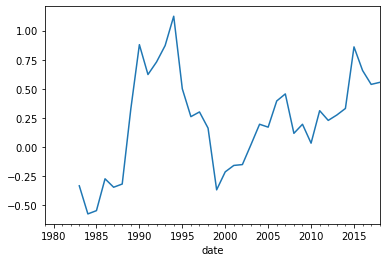

In [7]:
## resamples data to daily
df_ann = new_df.ANOM.resample('A', label='right').mean()
test = df_ann.rolling(5).mean()
test.plot()

In [8]:
new_df1['AO_CAT'] = 0
new_df1.loc[new_df1['COND']=='POSITIVE', 'AO_CAT'] = 1
new_df1.loc[new_df1['COND']=='NEGATIVE', 'AO_CAT'] = 2
new_df1

,AR_CAT,AR_CAT1,AR_CAT2,AR_CAT3,YEAR,MON,DAY,ANOM,COND,AO_CAT
date,,,,,,,,,,
1979-03-01 09:00:00,0,0,0,0,1979,3,1,0.372,POSITIVE,1
1979-03-02 09:00:00,0,0,0,0,1979,3,2,0.737,POSITIVE,1
1979-03-03 09:00:00,0,0,0,0,1979,3,3,1.127,POSITIVE,1
1979-03-04 09:00:00,0,0,0,0,1979,3,4,1.264,POSITIVE,1
1979-03-05 09:00:00,0,0,0,0,1979,3,5,1.414,POSITIVE,1
...,...,...,...,...,...,...,...,...,...,...
2018-05-27 09:00:00,0,0,0,0,2018,5,27,0.861,POSITIVE,1
2018-05-28 09:00:00,0,0,0,0,2018,5,28,1.036,POSITIVE,1
2018-05-29 09:00:00,0,0,0,0,2018,5,29,0.665,POSITIVE,1


In [9]:
# construct lists - to create df later
lst1 = []
lst2 = []
lst3 = []
lst4 = []
lst5 = []

cond = ['NEGATIVE', 'POSITIVE']
for i in range(2):
    # count total number of days in each phase
    idx = (new_df['COND'] == cond[i]) 
    p_len = len(new_df.loc[idx])
    print(p_len)
    
    # loop through AR Cat
    for j in range(3):
        # count number of each ARCAT that are also MJO phase
        idx = (new_df['COND'] == cond[i]) & (new_df['AR_CAT'] == j+1)
        arcat_ao = len(new_df.loc[idx])
        
        lst1.append(i)
        lst2.append(j+1)
        lst3.append(p_len)
        lst4.append(arcat_ao)
        lst5.append((arcat_ao/p_len)*100)
        
# # convert lists to dataframe
dfObj = pd.DataFrame(list(zip(lst1, lst2, lst3, lst4, lst5)), columns =['PHA' , 'ARCAT', 'AO_len', 'FREQ', 'percFREQ']) 
dfObj

190
251


,PHA,ARCAT,AO_len,FREQ,percFREQ
0,0,1,190,83,43.684211
1,0,2,190,75,39.473684
2,0,3,190,32,16.842105
3,1,1,251,71,28.286853
4,1,2,251,71,28.286853
5,1,3,251,109,43.426295


/home/nash/DATA/repositories/AR_types/figs/AO_barplot_mam.png


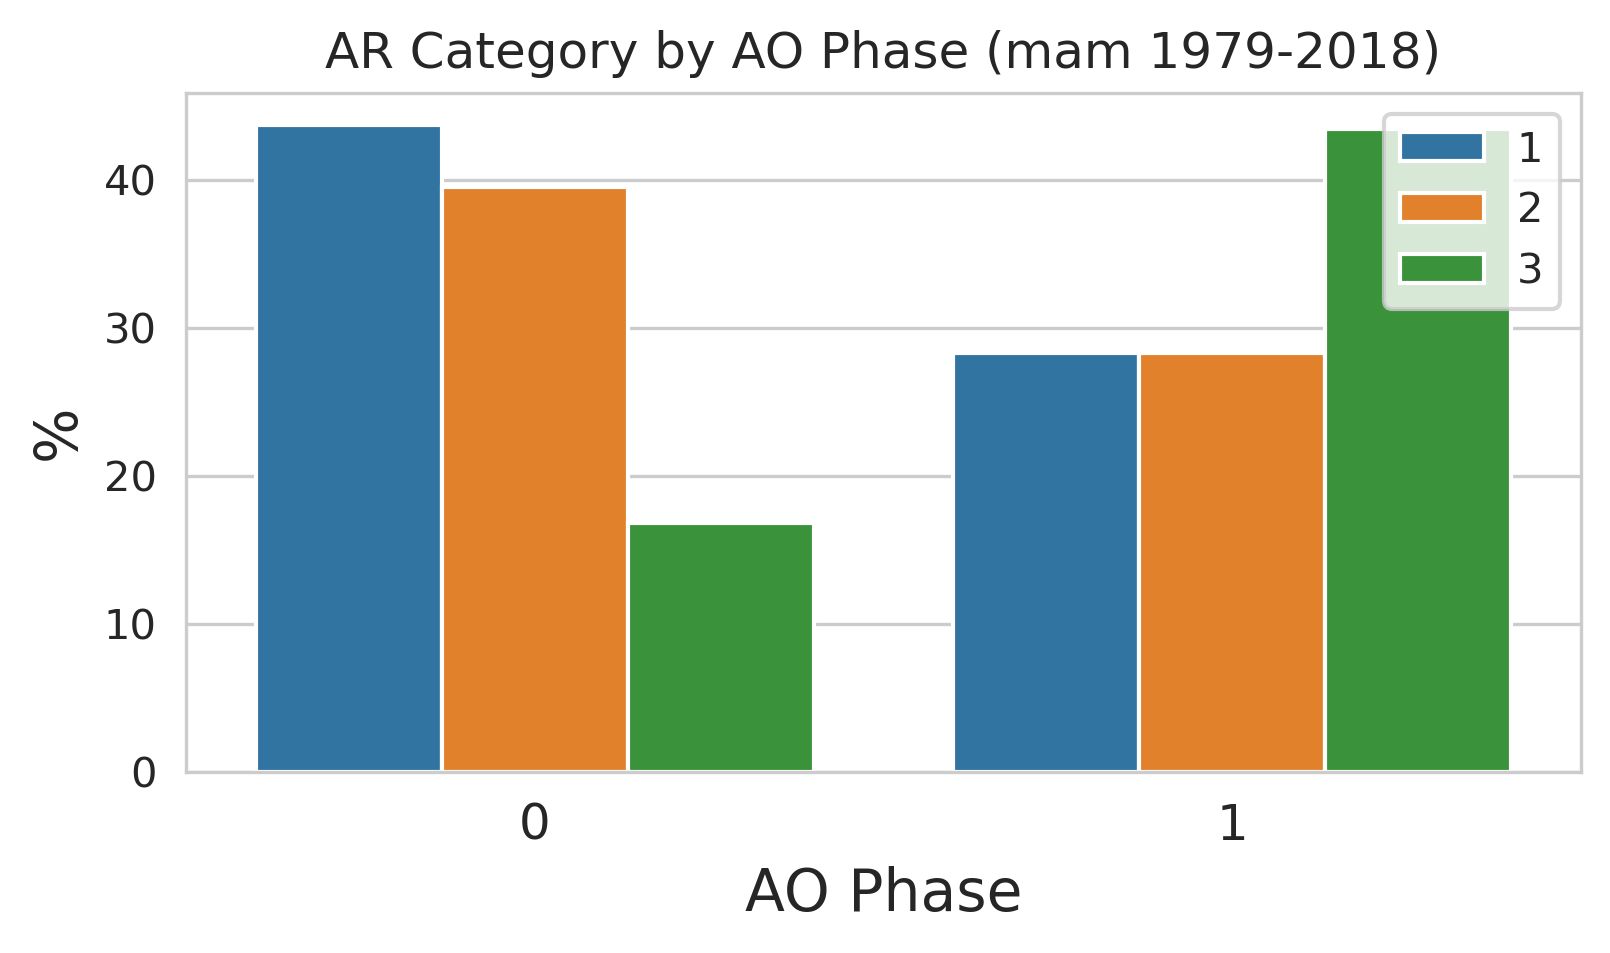

<Figure size 1800x900 with 0 Axes>

In [10]:
fname = path_to_figs + 'AO_barplot_' + ssn
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((6.0,3.0))
fig.dpi = 300
nplots=1

flatui = ["gold","lightcoral", "rebeccapurple"]
columns= np.arange(0, 9, 1)
          
sns.set_style("whitegrid")
# sns.set_context("paper")
sns.despine()

for i in np.arange(nplots):
    ax = fig.add_subplot(1, 1, i+1)
    sns.barplot(x='PHA', y='percFREQ', hue='ARCAT', data=dfObj)
    ax.set_ylabel('%', fontsize=14)
    ax.set_title('AR Category by AO Phase ({0} 1979-2018)'.format(ssn), fontsize=12)
    ax.set_xlabel('AO Phase', fontsize=14)
    ax.set_xticklabels(columns, fontsize=12)
    ax.legend(loc='upper right')
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

In [11]:
# fname = './results/season_AO_freq'
# fmt = 'png'
# fig = plt.figure()
# fig.set_size_inches((8.5,11.0))
# fig.dpi = 300
# nplots=4

# df = [DJF, MAM, JJA, SON]
# ssn_label = ['DJF', 'MAM', 'JJA', 'SON']
# flatui = ['c', 'red']

# for i in np.arange(nplots):
#     ax = fig.add_subplot(4, 1, i+1)
#     data = df[i]
#     sns.barplot(x=data.index.year, y='total', hue='COND',
#                 data=data, palette=flatui, dodge=False)
#     sns.set_style("ticks")
#     ax.set_ylabel('# of AR Days', fontsize=12)
#     ax.set_xlabel('')
# # 
#     # Format the x axis
#     ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
# #     ax.xaxis.set_major_formatter(DateFormatter('%Y'))
#     ax.set_xticklabels(np.arange(1975, 2020, 5), fontsize=12)
#     ax.legend(loc='upper center')
#     plt.gca().legend().set_title('')
#     plt.ylim(0, 60)
#     ax.set_title(ssn_label[i], loc='left')
    
# plt.tight_layout()
# # Save the figure
# fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
# fig.clf()

# plotFile = fname + '.png'
# print(plotFile)
# display(Image(plotFile))

In [12]:
def _zstat_generic(value1, value2, std_diff, alternative, diff=0):
    '''generic (normal) z-test to save typing

    can be used as ztest based on summary statistics

    '''
    zstat = (value1 - value2 - diff) / std_diff
    if alternative in ['two-sided', '2-sided', '2s']:
        pvalue = stats.norm.sf(np.abs(zstat))*2
    elif alternative in ['larger', 'l']:
        pvalue = stats.norm.sf(zstat)
    elif alternative in ['smaller', 's']:
        pvalue = stats.norm.cdf(zstat)
    else:
        raise ValueError('invalid alternative')
    return zstat, pvalue

def ztest(x1, x2=None, value=0, alternative='two-sided', usevar='pooled',
          ddof=1.):
    '''test for mean based on normal distribution, one or two samples

    In the case of two samples, the samples are assumed to be independent.

    Parameters
    ----------
    x1 : array_like, 1-D or 2-D
        first of the two independent samples
    x2 : array_like, 1-D or 2-D
        second of the two independent samples
    value : float
        In the one sample case, value is the mean of x1 under the Null
        hypothesis.
        In the two sample case, value is the difference between mean of x1 and
        mean of x2 under the Null hypothesis. The test statistic is
        `x1_mean - x2_mean - value`.
    alternative : string
        The alternative hypothesis, H1, has to be one of the following

           'two-sided': H1: difference in means not equal to value (default)
           'larger' :   H1: difference in means larger than value
           'smaller' :  H1: difference in means smaller than value

    usevar : string, 'pooled'
        Currently, only 'pooled' is implemented.
        If ``pooled``, then the standard deviation of the samples is assumed to be
        the same. see CompareMeans.ztest_ind for different options.
    ddof : int
        Degrees of freedom use in the calculation of the variance of the mean
        estimate. In the case of comparing means this is one, however it can
        be adjusted for testing other statistics (proportion, correlation)

    Returns
    -------
    tstat : float
        test statisic
    pvalue : float
        pvalue of the t-test

    Notes
    -----
    usevar not implemented, is always pooled in two sample case
    use CompareMeans instead.

    '''
    #usevar is not used, always pooled

    if usevar != 'pooled':
        raise NotImplementedError('only usevar="pooled" is implemented')

    x1 = np.asarray(x1)
    nobs1 = x1.shape[0]
    x1_mean = x1.mean(0)
    x1_var = x1.var(0)
    if x2 is not None:
        x2 = np.asarray(x2)
        nobs2 = x2.shape[0]
        x2_mean = x2.mean(0)
        x2_var = x2.var(0)
        var_pooled = (nobs1 * x1_var + nobs2 * x2_var)
        var_pooled /= (nobs1 + nobs2 - 2 * ddof)
        var_pooled *= (1. / nobs1 + 1. / nobs2)
    else:
        var_pooled = x1_var / (nobs1 - ddof)
        x2_mean = 0

    std_diff = np.sqrt(var_pooled)
    #stat = x1_mean - x2_mean - value
    return _zstat_generic(x1_mean, x2_mean, std_diff, alternative, diff=value)

def season_zstat(df):
    zstat_array = []
    pval_array = []
    
    s_positive = df.loc[(df['ANOM'] > 0)]
    s_negative = df.loc[(df['ANOM'] < 0)]

    for i, subregion in enumerate(('AR_CAT1', 'AR_CAT2', 'AR_CAT3')):
        zstat, pval = ztest(s_positive[subregion].values, s_negative[subregion].values)
        
        zstat_array.append((zstat))
        pval_array.append((pval))
        
        zstat_final = zstat_array 
        pval_final = pval_array
    return zstat_final, pval_final

In [13]:
z, p = season_zstat(new_df)
arrays = [['AO+ - AO-', 'AO+ - AO-', 'AO+ - AO-'],
           ['AR_CAT1', 'AR_CAT2', 'AR_CAT3']]
index = pd.MultiIndex.from_arrays(arrays, names=('% of AR Days', 'Subregion'))
df_z = pd.DataFrame({'zstat': z,
                    'pval': p},
                   index=index)
df_z

zstat          pval
% of AR Days Subregion                        
AO+ - AO-    AR_CAT1   -3.394829  6.867140e-04
             AR_CAT2   -2.483680  1.300326e-02
             AR_CAT3    6.164943  7.050856e-10

## Plot Composite

In [14]:
plot_dict_upper = config['upper_diff']
plot_dict_ivt = config['ivt_diff']
plot_dict_prec = config['precip_diff']

plot_dicts = [plot_dict_upper, plot_dict_ivt, plot_dict_prec]

In [15]:
def preprocess(ds):
    '''keep only selected lats and lons'''
    if plot_dict['name'] == 'huv250':
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=plot_dict['lev'])
    else:
        subset = ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
    return subset

f = []
# Select lat/lon grid
lonmin = plot_dicts[1]['bnds'][0]
lonmax = plot_dicts[1]['bnds'][1]
latmin = plot_dicts[1]['bnds'][2]
latmax = plot_dicts[1]['bnds'][3]

    
for p, plot_dict in enumerate(plot_dicts):

    # # open data  
    f.append(xr.open_mfdataset(path_to_data + plot_dict['fname'] , preprocess=preprocess, combine='by_coords'))

In [16]:
var_dict = {'H': (['time', 'lat', 'lon'], f[0]['z'].values/(9.80665*10)), # convert to geopotential height (m)
            'U': (['time', 'lat', 'lon'], f[0]['u'].values),
            'V': (['time', 'lat', 'lon'], f[0]['v'].values),
            'ivte': (['time', 'lat', 'lon'], f[1]['p71.162'].values),
            'ivtn': (['time', 'lat', 'lon'], f[1]['p72.162'].values)}


ds = xr.Dataset(var_dict,
                coords={'time': (['time'], f[0]['time'].values),
                        'lat': (['lat'], f[0]['latitude'].values),
                        'lon': (['lon'], f[0]['longitude'].values)})

ds2 = xr.Dataset({'prec': (['time', 'lat', 'lon'], f[2]['mtpr'].values*86400)},
                coords={'time': (['time'], f[2]['time'].values),
                        'lat': (['lat'], f[2]['latitude'].values),
                        'lon': (['lon'], f[2]['longitude'].values)})
ds
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds size in GB 5.34



In [17]:
# Trim date range
idx = slice(ar_dict['start_date'], ar_dict['end_date'])
ds = ds.sel(time=idx)
ds2 = ds2.sel(time=idx)

# Select DJF months
# Select months
if ar_dict['mon_s'] > ar_dict['mon_e']:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
else:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])
    
ds = ds.sel(time=idx)
ds2 = ds2.sel(time=idx)

# Combine AR Cat data w/ reanalysis data
# Add ar time series to the ERA dataset
ds['ar'] = ('time', new_df1.AR_CAT)
ds['ao'] = ('time', new_df1.AO_CAT)
ds = ds.set_coords(('ar','ao'))
ds

ds2['ar'] = ('time', new_df1.AR_CAT)
ds2['ao'] = ('time', new_df1.AO_CAT)
ds2 = ds2.set_coords(('ar','ao'))

In [18]:
def select_ar_days(era, lag=0):
    # Select only AR days
    idx = (era.ar >= 1)
    # select days with lag shift
    era_ar = era.shift(time=lag).sel(time=idx)
    # print results
    print(era_ar)
    
    return era_ar

era_ar = select_ar_days(era=ds, lag=0)
era_ar2 = select_ar_days(era=ds2, lag=0)

<xarray.Dataset>
Dimensions:  (lat: 101, lon: 181, time: 441)
Coordinates:
  * time     (time) datetime64[ns] 1979-03-08T09:00:00 ... 2018-05-14T09:00:00
  * lat      (lat) float32 50.0 49.5 49.0 48.5 48.0 47.5 ... 2.0 1.5 1.0 0.5 0.0
  * lon      (lon) float32 30.0 30.5 31.0 31.5 32.0 ... 118.5 119.0 119.5 120.0
    ar       (time) int64 2 2 2 1 2 1 1 3 2 3 2 1 1 ... 1 2 2 2 3 2 2 1 2 2 3 1
    ao       (time) int64 1 1 2 2 2 2 2 1 2 2 1 1 2 ... 1 2 2 2 2 2 2 2 2 2 1 1
Data variables:
    H        (time, lat, lon) float32 1013.06335 1013.06335 ... 1098.045
    U        (time, lat, lon) float32 4.6215105 4.027273 ... -3.9774399
    V        (time, lat, lon) float32 -0.07186985 -0.24861336 ... -4.5299044
    ivte     (time, lat, lon) float32 -4.792862 -8.968933 ... -204.41852
    ivtn     (time, lat, lon) float32 26.586868 26.146576 ... -12.252945
<xarray.Dataset>
Dimensions:  (lat: 201, lon: 361, time: 441)
Coordinates:
  * time     (time) datetime64[ns] 1979-03-08T09:00:00 ... 2018-05

In [19]:
# # Compute composites of each AR type
# era_ar_comp = era_ar_lag.groupby('ar').mean('time')
# era_ar_comp1 = era_ar_lag2.groupby('ar').mean('time')

d = []
d2 = []

artype_lst = [1, 2, 3] # type 1, type 2, type 3

for k, ar_type in enumerate(artype_lst):
    # conditions for AO+
    idx_aopos = (era_ar.ao == 1) & (era_ar.ar == ar_type)
    ao_pos = era_ar.sel(time=idx_aopos).mean('time')
    
    # conditions for AO-
    idx_aoneg = (era_ar.ao == 2) & (era_ar.ar == ar_type)
    ao_neg = era_ar.sel(time=idx_aoneg).mean('time')
    
    # TO DO: ADD SIGNIFICANCE TEST
    
    # subtract AO- from AO+
    d.append(ao_pos - ao_neg)
    
    ### Repeat for prec ds
    # conditions for AO+
    idx_aopos = (era_ar2.ao == 1) & (era_ar2.ar == ar_type)
    ao_pos = era_ar2.sel(time=idx_aopos).mean('time')
    
    # conditions for AO-
    idx_aoneg = (era_ar2.ao == 2) & (era_ar2.ar == ar_type)
    ao_neg = era_ar2.sel(time=idx_aoneg).mean('time')
    
    # TO DO: ADD SIGNIFICANCE TEST
    
    # subtract AO- from AO+
    d2.append(ao_pos - ao_neg)
    



In [20]:
# 9-panel plot    
panel_9 = {'nrows': 3,
            'ncols': 3,
            'artype_lst': [2, 0, 1],
            'panel': '9pan'}

panel_dict = panel_9

In [21]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()    # map/destination

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)


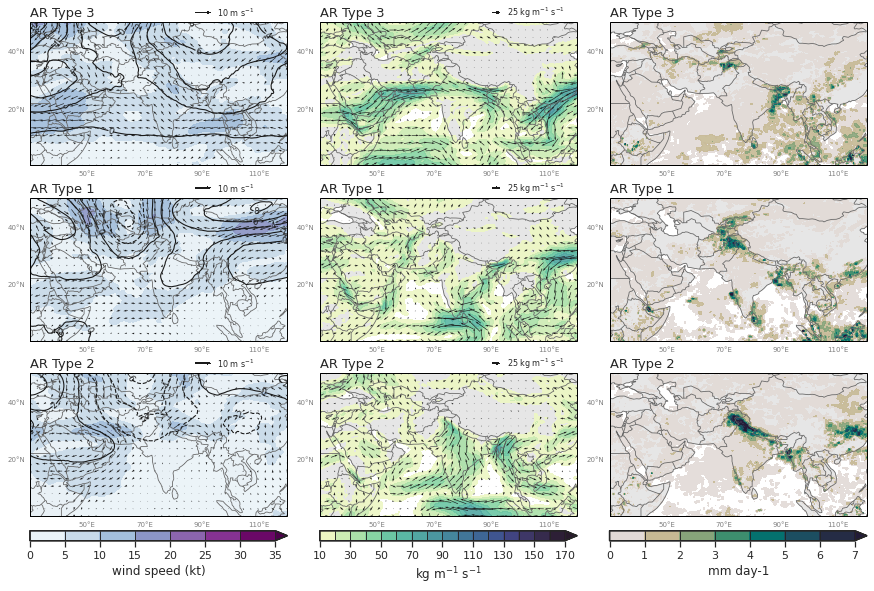

In [23]:
fig_dict = panel_dict
filepath = path_to_figs + 'composites/teleconnections' + '/' + 'AO_all_vars_' + ar_dict['ssn'] + fig_dict['panel'] + '.png'    
nrows = fig_dict['nrows']
ncols = fig_dict['ncols']
artype_lst = fig_dict['artype_lst']

# Create figure
fig = plt.figure(figsize=(15,10))

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='bottom', cbar_mode='edge',
                cbar_pad=0.20, cbar_size='7%',label_mode='',
                direction='column')

#################################
########## UPPER PLOTS ##########
#################################
for k, (ax, ar_type) in enumerate(zip(axgr[0:3], artype_lst)):
    data = d[ar_type]
    plot_dict = plot_dict_upper
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled

    # 250-hPa Winds (m/s)
    uwnd = data.U.values * units('m/s')
    vwnd = data.V.values * units('m/s')
    wspd = mpcalc.wind_speed(uwnd, vwnd)
    # 250-hPa Winds (knots)
    uwnd_kt = wspd.to('kt')
    vwnd_kt = wspd.to('kt')
    wspd_kt = wspd.to('kt')
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max')
    
    # Contour Lines

    # 250-hPa Heights
    hgts = data.H.values
    clevs = np.arange(plot_dict['clevs'][0], plot_dict['clevs'][1], plot_dict['clevs'][2])
    cs = ax.contour(lons, lats, hgts, transform=datacrs,
                    levels=clevs, colors='k', linewidths=1.1)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)  
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
                  color='k', regrid_shape=20, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                     coordinates='axes', fontproperties={'size': 8.0})
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type+1)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])

################################
########## IVT PLOTS ###########
################################
for k, (ax, ar_type) in enumerate(zip(axgr[3:6], artype_lst)):
    data = d[ar_type]
    plot_dict = plot_dict_ivt
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled
        
    # IVT (filled contour)
    uvec = data.ivte.values
    vvec = data.ivtn.values
    ivt = np.sqrt(uvec**2 + vvec**2)
    cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=plot_dict['cmap'], alpha=0.9, extend='max') 
        
    # Wind barbs / vectors
    Q = ax.quiver(lons, lats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=20, pivot='middle',
                  angles='xy', scale_units='xy', scale=plot_dict['quiver_scale'], units='xy')
    
    # quiver key
    qk = ax.quiverkey(Q, 0.7, 1.07, plot_dict['quiver_key'], plot_dict['quiver_key_lbl'], labelpos='E',
                          coordinates='axes', fontproperties={'size': 8.0})
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type+1)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
# Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[1], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])

################################
########## PREC PLOTS ##########
################################

for k, (ax, ar_type) in enumerate(zip(axgr[6:], artype_lst)):
    data = d2[ar_type]
    plot_dict = plot_dict_prec
    # lat/lon arrays
    lats = data.lat.values
    lons = data.lon.values    
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled

    # Precip (filled contour)
    cflevs = np.arange(0, 8, 1)
#     cflevs = np.arange(plot_dict['cflevs'][0], plot_dict['cflevs'][1], plot_dict['cflevs'][2])
    if plot_dict['anom'] == 'anom':
        cmap = cmocean.tools.crop(cmo.balance, vmin=-6., vmax=22., pivot=0., N=None, dmax=None)
    if plot_dict['anom'] == 'nanom':
        cmap = plot_dict['cmap']
    prec = data.prec.values
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    
    # subtitles
    plt_label = 'AR Type {0}'.format(ar_type+1)
    ax.set_title(plt_label, loc='left',fontsize=13)
    
# # Colorbar (single)
    cb = fig.colorbar(cf, axgr.cbar_axes[2], orientation='horizontal', drawedges=True, extend='both')
    cb.set_label(plot_dict['cb_label'])
    
# Save figure
plt.savefig(filepath, dpi=150, bbox_inches='tight')

# Show
plt.show()
